# Preprocessing Data
This file is used to be standard of preprocessing in the project. The new experiment can copy to use it own.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np

from mne.datasets import eegbci

## 1. Class

In [2]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = 'MNE-eegbci-data/files/eegmmidb/1.0.0'
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        raw_subjects = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            raw_subject = []
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                raw_subject.append(raw)
                count += 1
            raw_subjects.append(mne.io.concatenate_raws(raw_subject))

        raw = mne.io.concatenate_raws(raws)         # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        # set montage to raw of all subjects
        for r in raw_subjects:
            eegbci.standardize(r)
            r.set_montage(montage)
        self.raw_subjects = raw_subjects
        print("Done.")
    
    def filter(self, freq):
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        
    def get_events(self, raw, verbose=None):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(raw, event_id=event_id, verbose=verbose)
        return events, event_id
    
    def get_epochs(self, raw, events, event_id, tmin=-1, tmax=4, verbose=None):
        picks = mne.pick_types(raw.info, eeg=True, exclude='bads')
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True, verbose=verbose)
        return epochs
    
    def create_epochs(self, tmin=-1, tmax=4):
        print(">>> Creating Epochs.")
        events, event_id = self.get_events(self.raw)
        self.epochs = self.get_epochs(self.raw, events, event_id, tmin, tmax)
        self.epochs_subjects = []
        
        print(">>> Creating Epochs each subjects.")
        for r in self.raw_subjects:
            r_events, r_event_id = self.get_events(r, verbose=False)
            r_e = self.get_epochs(r, events, event_id, tmin, tmax, verbose=False)
            self.epochs_subjects.append(r_e)
        print("Done.")
    
    def get_X_y(self, tmin=-1, tmax=4):
        if self.epochs is None:
            self.create_epochs(tmin, tmax)
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y
    
    def get_X_y_each_subject(self, tmin=-1, tmax=4):
        if self.epochs is None:
            self.create_epochs(tmin, tmax)
        X = []
        y = []
        for e in self.epochs_subjects:
            X_t = e.get_data()
            y_t = e.events[:, -1]
            X.append(X_t)
            y.append(y_t)
        return X, y

### 1.1. Load dataset and setting subjects

In [3]:
# home directory + datasets folder
path = os.path.join(os.path.expanduser("~"), 'datasets')
base_url = 'https://physionet.org/files/eegmmidb/1.0.0/'
# subjects = [1]
runs = [3, 7]
subjects = [i for i in range(1, 11)]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)

>>> Start download from: https://physionet.org/files/eegmmidb/1.0.0/.
Done.
>>> Extract all subjects from: C:\Users\supha\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0.
Loading file #1/20: S001R03.edf
Loading file #2/20: S001R07.edf
Loading file #3/20: S002R03.edf
Loading file #4/20: S002R07.edf
Loading file #5/20: S003R03.edf
Loading file #6/20: S003R07.edf
Loading file #7/20: S004R03.edf
Loading file #8/20: S004R07.edf
Loading file #9/20: S005R03.edf
Loading file #10/20: S005R07.edf
Loading file #11/20: S006R03.edf
Loading file #12/20: S006R07.edf
Loading file #13/20: S007R03.edf
Loading file #14/20: S007R07.edf
Loading file #15/20: S008R03.edf
Loading file #16/20: S008R07.edf
Loading file #17/20: S009R03.edf
Loading file #18/20: S009R07.edf
Loading file #19/20: S010R03.edf
Loading file #20/20: S010R07.edf
Done.


## 2. Filter

In [4]:
# apply filter
freq = (8., 30.)
eeg.filter(freq=freq)

eeg.create_epochs(tmin=1, tmax=2)

>>> Apply filter.
Filtering raw data in 30 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)

>>> Creating Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
450 matching events found
No baseline correction applied
0 projection items activated
Loading data for 450 events and 161 original time points ...
0 bad epochs dropped
>>> Creating Epochs each subjects.
Done.


## 3. Get parameters

### 3.1. X, y

In [5]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)

(450, 64, 161) (450,)


List of X and y of all subjects

In [6]:
X_list, y_list = eeg.get_X_y_each_subject()

print(len(X_list), len(y_list))

10 10


### 3.2. Raw

In [7]:
eeg.raw

<RawEDF | S001R03.edf, 64 x 593280 (3708.0 s), ~289.8 MB, data loaded>

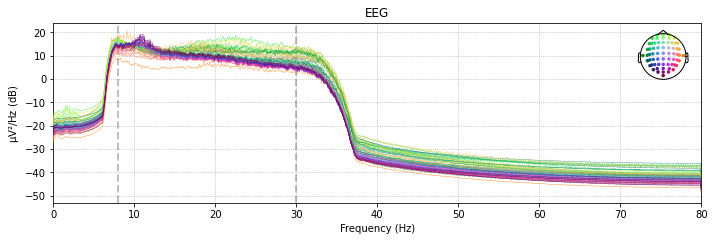

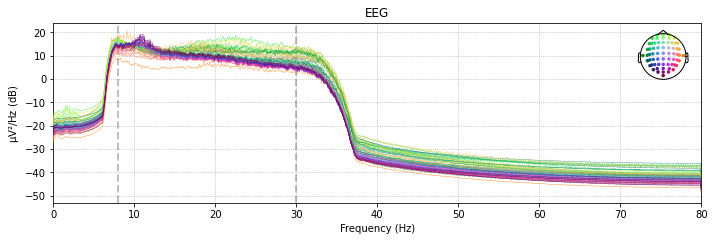

In [8]:
eeg.raw.plot_psd()

### 3.3. Epoch

In [9]:
eeg.epochs

Number of events,450
Events,T1: 227T2: 223
Time range,1.000 – 2.000 sec
Baseline,off


In [10]:
print(len(eeg.epochs_subjects))
eeg.epochs_subjects

10


[<Epochs |  450 events (all good), 1 - 2 sec, baseline off, ~35.5 MB, data loaded,
  'T1': 227
  'T2': 223>,
 <Epochs |  29 events (all good), 1 - 2 sec, baseline off, ~2.4 MB, data loaded,
  'T1': 15
  'T2': 14>,
 <Epochs |  30 events (all good), 1 - 2 sec, baseline off, ~2.4 MB, data loaded,
  'T1': 16
  'T2': 14>,
 <Epochs |  29 events (all good), 1 - 2 sec, baseline off, ~2.4 MB, data loaded,
  'T1': 15
  'T2': 14>,
 <Epochs |  29 events (all good), 1 - 2 sec, baseline off, ~2.4 MB, data loaded,
  'T1': 15
  'T2': 14>,
 <Epochs |  29 events (all good), 1 - 2 sec, baseline off, ~2.4 MB, data loaded,
  'T1': 15
  'T2': 14>,
 <Epochs |  30 events (all good), 1 - 2 sec, baseline off, ~2.4 MB, data loaded,
  'T1': 16
  'T2': 14>,
 <Epochs |  29 events (all good), 1 - 2 sec, baseline off, ~2.4 MB, data loaded,
  'T1': 15
  'T2': 14>,
 <Epochs |  29 events (all good), 1 - 2 sec, baseline off, ~2.4 MB, data loaded,
  'T1': 15
  'T2': 14>,
 <Epochs |  29 events (all good), 1 - 2 sec, baseli

## 4. Process Data

### 4.1. Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape)

(315, 64, 161) (315,)


### To be continue...